In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers



In [2]:
%pwd
img_folder='/archive/img/'

In [ ]:
df = pd.DataFrame(columns=['filename','extension','label','labelsize','char1','char2','char3','char4','char5'])
i = 0
for _, _, files in os.walk(img_folder):
    for f in files:
        df.loc[i,'filename'] = f
        df.loc[i,'extension'] = f.split('.')[1]
        df.loc[i,'label'] = f.split('.')[0]
        df.loc[i,'labelsize'] = len(f.split('.')[0])
        df.loc[i,'char1'] = f.split('.')[0][0]
        df.loc[i,'char2'] = f.split('.')[0][1]
        df.loc[i,'char3'] = f.split('.')[0][2]
        df.loc[i,'char4'] = f.split('.')[0][3]
        df.loc[i,'char5'] = f.split('.')[0][4]
        i = i+1


In [25]:
df.to_csv('ml_proj.csv')

In [4]:
df=pd.read_csv("ml_proj.csv")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64961 entries, 0 to 64960
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filename   64961 non-null  object
 1   extension  64961 non-null  object
 2   label      64961 non-null  object
 3   labelsize  64961 non-null  int64 
 4   char1      64961 non-null  object
 5   char2      64961 non-null  object
 6   char3      64961 non-null  object
 7   char4      64961 non-null  object
 8   char5      64961 non-null  object
 9   char6      64961 non-null  object
dtypes: int64(1), object(9)
memory usage: 5.0+ MB


In [6]:
df.value_counts()

filename    extension  label   labelsize  char1  char2  char3  char4  char5  char6
000s72.png  png        000s72  6          0      0      0      s      7      2        1
nvz7oj.png  png        nvz7oj  6          n      v      z      7      o      j        1
nvq3mi.png  png        nvq3mi  6          n      v      q      3      m      i        1
nvqmn4.png  png        nvqmn4  6          n      v      q      m      n      4        1
nvu23w.png  png        nvu23w  6          n      v      u      2      3      w        1
                                                                                     ..
bw2q7m.png  png        bw2q7m  6          b      w      2      q      7      m        1
bw2vsa.png  png        bw2vsa  6          b      w      2      v      s      a        1
bw2w8b.png  png        bw2w8b  6          b      w      2      w      8      b        1
bw3nrg.png  png        bw3nrg  6          b      w      3      n      r      g        1
zzzjgm.png  png        zzzjgm  6     

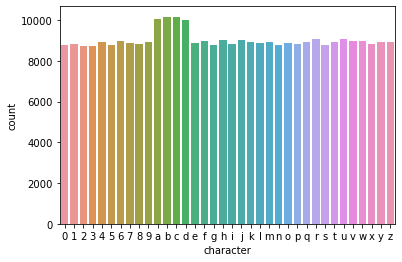

In [7]:
data = pd.DataFrame(df['char1'].value_counts()+df['char2'].value_counts()+df['char3'].value_counts()+df['char4'].value_counts()+df['char5'].value_counts()).reset_index()
data.columns = ['character','count']

sns.barplot(data=data, x='character', y='count')
plt.show()

In [16]:
data

,character,count
0,0,8793
1,1,8831
2,2,8730
3,3,8742
4,4,8929
5,5,8789
6,6,8955
7,7,8872
8,8,8829
9,9,8902


In [3]:
char_to_num = {'0':0,'1':1,'2':2,'3':3,'4':4,'5':5,'6':6,'7':7,'8':8,'9':9
               ,'a':10,'b':11,'c':12,'d':13,'e':14,'f':15,'g':16,'h':17,'i':18,
              'j':19,'k':20,'l':21,'m':22,'n':23,'o':24,'p':25,'q':26,'r':27,
               's':28,'t':29,'u':30,'v':31,'w':32,'x':33,'y':34,'z':35}

In [4]:
def encode_single_sample(img_path, label, crop):
    # Read image file and returns a tensor with dtype=string
    img = tf.io.read_file(img_path)
    # Decode and convert to grayscale (this conversion does not cause any information lost and reduces the size of the tensor)
    # This decode function returns a tensor with dtype=uint8
    img = tf.io.decode_png(img, channels=1) 
    # Scales and returns a tensor with dtype=float32
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Crop and resize to the original size : 
    # top-left corner = offset_height, offset_width in image = 0, 25 
    # lower-right corner is at offset_height + target_height, offset_width + target_width = 50, 150
    if(crop==True):
        img = tf.image.crop_to_bounding_box(img, offset_height=0, offset_width=75, target_height=100, target_width=145)
        img = tf.image.resize(img,size=[50,200],method='bilinear', preserve_aspect_ratio=False,antialias=False, name=None)
    # Transpose the image because we want the time dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # Converts the string label into an array with 5 integers. E.g. '6n6gg' is converted into [6,16,6,14,14]
    label = list(map(lambda x:char_to_num[x], label))
    return img.numpy(), label


In [5]:
img_folder = "/Users/Acer/archive/img/"
def create_train_and_validation_datasets(crop=False):
    # Loop on all the files to create X whose shape is (1040, 50, 200, 1) and y whose shape is (1040, 5)
    X, y = [],[]

    for _, _, files in os.walk(img_folder):
        for f in files:
            # To start, let's ignore the jpg images
            label = f.split('.')[0]
            extension = f.split('.')[1]
            if extension=='png':
                img, label = encode_single_sample(img_folder+f, label,crop)
                X.append(img)
                y.append(label)

    X = np.array(X)
    y = np.array(y)
    X_train, X_val, y_train, y_val = train_test_split(X.reshape(64961, 10000), y, test_size=0.1, shuffle=True, random_state=42)
    X_train, X_val = X_train.reshape(58464,200,50,1), X_val.reshape(6497,200,50,1)
    return X_train, X_val, y_train, y_val

In [21]:
img_folder = "/Users/Acer/archive/img/"
def create_train_and_validation_datasets2(crop=False):
    # Loop on all the files to create X whose shape is (1040, 50, 200, 1) and y whose shape is (1040, 5)
    X, y = [],[]

    for _, _, files in os.walk(img_folder):
        for f in files:
            # To start, let's ignore the jpg images
            label = f.split('.')[0]
            extension = f.split('.')[1]
            if extension=='png':
                img, label = encode_single_sample(img_folder+f, label,crop)
                X.append(img)
                y.append(label)

    X = np.array(X)
    y = np.array(y)
    X_train, X_val, y_train, y_val = train_test_split(X.reshape(36, 30000), y, test_size=0.1, shuffle=True, random_state=42)
    X_train, X_val = X_train.reshape(32,300,100,1), X_val.reshape(4,300,100,1)
    return X_train, X_val, y_train, y_val

In [12]:
X_train_, X_val_, y_train_, y_val_ = create_train_and_validation_datasets(crop=False)
X_train_, X_val_, y_train_, y_val_ = create_train_and_validation_datasets2(crop=False)

(-0.5, 49.5, 199.5, -0.5)

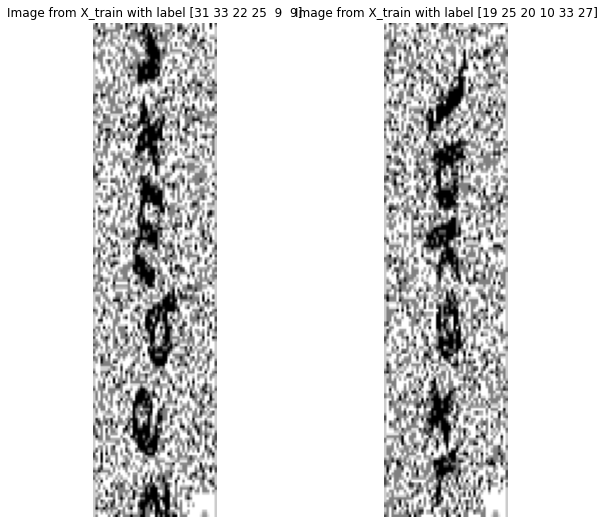

In [30]:
fig=plt.figure(figsize=(20, 20))
fig.add_subplot(2, 4, 1)
plt.imshow(X_train[0], cmap='gray')
plt.title('Image from X_train with label '+ str(y_train[0]))
plt.axis('off')
fig.add_subplot(2, 4, 2)
plt.imshow(X_train[2], cmap='gray')
plt.title('Image from X_train with label '+ str(y_train[2]))
plt.axis('off')

In [7]:
def build_model():
    
    # Inputs to the model
    input_img = layers.Input(shape=(200,50,1), name="image", dtype="float32") 

    # First conv block
    x = layers.Conv2D(32,(3, 3),activation="relu",kernel_initializer="he_normal",padding="same",name="Conv1")(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(64,(3, 3),activation="relu",kernel_initializer="he_normal",padding="same",name="Conv2")(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64 --> output volume shape = (50,12,64) 
    # Reshape to "split" the volume in 5 time-steps
    x = layers.Reshape(target_shape=(6, 6400), name="reshape")(x)

    # FC layers
    x = layers.Dense(256, activation="relu", name="dense1")(x)
    x = layers.Dense(128, activation="relu", name="dense2")(x)
    x = layers.Dense(64, activation="relu", name="dense3")(x)
    output = layers.Dense(36, activation="softmax", name="dense4")(x) 
    
    # Define the model
    model = keras.models.Model(inputs=input_img, outputs=output, name="ocr_classifier_based_model")
    
    # Compile the model and return
    model.compile(optimizer=keras.optimizers.Adam(), loss="sparse_categorical_crossentropy", metrics="accuracy")
    return model


# Get the model
model = build_model()
model.summary()

Model: "ocr_classifier_based_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 6, 6400)           0         
                                                                 
 dense1 (Dense)              (None, 6, 2

In [22]:
X_train, X_val, y_train, y_val = create_train_and_validation_datasets(crop=True)

In [190]:
history = model.fit(x=X_train, y=y_train, validation_data=(X_val, y_val), epochs=30)

Epoch 1/30
1827/1827 [==============================] - 280s 153ms/step - loss: 0.8076 - accuracy: 0.7736 - val_loss: 0.3334 - val_accuracy: 0.9046
Epoch 2/30
1827/1827 [==============================] - 287s 157ms/step - loss: 0.2710 - accuracy: 0.9251 - val_loss: 0.2777 - val_accuracy: 0.9212
Epoch 3/30
1827/1827 [==============================] - 315s 172ms/step - loss: 0.2067 - accuracy: 0.9420 - val_loss: 0.2236 - val_accuracy: 0.9395
Epoch 4/30
1827/1827 [==============================] - 349s 191ms/step - loss: 0.1694 - accuracy: 0.9511 - val_loss: 0.2272 - val_accuracy: 0.9372
Epoch 5/30
1827/1827 [==============================] - 360s 197ms/step - loss: 0.1416 - accuracy: 0.9579 - val_loss: 0.2164 - val_accuracy: 0.9409
Epoch 6/30
1827/1827 [==============================] - 364s 199ms/step - loss: 0.1193 - accuracy: 0.9633 - val_loss: 0.2258 - val_accuracy: 0.9405
Epoch 7/30
1827/1827 [==============================] - 372s 204ms/step - loss: 0.0999 - accuracy: 0.9683 - val_

In [191]:
model.save_weights('./checkpoints/my_checkpoint')

In [192]:
df

,filename,extension,label,labelsize,char1,char2,char3,char4,char5,char6
0,000s72.png,png,000s72,6,0,0,0,s,7,2
1,000swu.png,png,000swu,6,0,0,0,s,w,u
2,001zf4.png,png,001zf4,6,0,0,1,z,f,4
3,00242v.png,png,00242v,6,0,0,2,4,2,v
4,00299t.png,png,00299t,6,0,0,2,9,9,t
...,...,...,...,...,...,...,...,...,...,...
64956,zzum7b.png,png,zzum7b,6,z,z,u,m,7,b
64957,zzwn92.png,png,zzwn92,6,z,z,w,n,9,2
64958,zzxd1e.png,png,zzxd1e,6,z,z,x,d,1,e
64959,zzz3mr.png,png,zzz3mr,6,z,z,z,3,m,r


In [23]:
y_pred = model.predict(X_val) # y_pred shape = (104,50,19)
y_pred = np.argmax(y_pred, axis=2)

204/204 [==============================] - 12s 43ms/step


In [194]:
y_pred

array([[29, 12,  1, 14,  7, 18],
       [ 9,  4, 13, 16, 13, 29],
       [17, 10, 33,  8, 16, 12],
       ...,
       [26,  7,  5, 13,  7, 14],
       [ 7, 19, 35, 27, 26, 19],
       [24,  8, 24,  2, 10, 34]], dtype=int64)

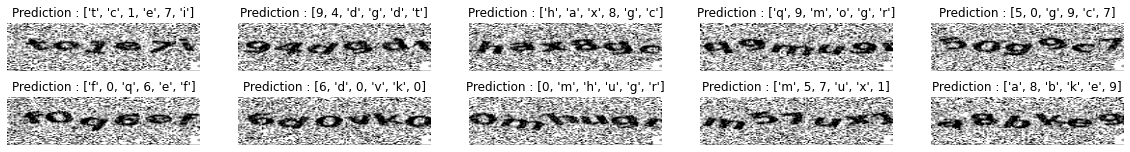

In [36]:
nrow = 1
fig=plt.figure(figsize=(20, 5))
for i in range(0,10):
    if i>4: nrow = 2
    fig.add_subplot(nrow, 5, i+1)
    plt.imshow(X_val[i].transpose((1,0,2)),cmap='gray')
    plt.title('Prediction : ' + str(list(map(lambda x:num_to_char[str(x)], y_pred[i]))))
    plt.axis('off')
plt.show() 